In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

In [14]:
data = pd.read_pickle('ass3.pickle', compression='infer', storage_options=None)
data

{'train':            f0    f1        f2        f3      f4        f5     f6      f7  \
 14981  4.0391  15.0  6.297710  0.992366   334.0  2.549618  32.72 -116.99   
 6614   4.7241  46.0  5.375758  0.954545   753.0  2.281818  34.17 -118.10   
 14233  3.3553   7.0  5.229213  1.101124  1304.0  2.930337  32.70 -117.01   
 1802   1.3929  52.0  5.000000  0.953488   126.0  2.930233  37.92 -122.36   
 6030   1.6006  52.0  4.427083  1.017361  1246.0  2.163194  34.07 -117.75   
 ...       ...   ...       ...       ...     ...       ...    ...     ...   
 4653   8.3617  52.0  5.516129       NaN   737.0  2.971774  34.06 -118.33   
 7250   2.5395  26.0  4.528600  1.053254  1777.0  3.504931  33.99 -118.12   
 17934  3.6118  48.0  4.387324  1.035211   697.0  2.454225  37.35 -121.95   
 1355   3.5436  16.0  5.013825  1.069124  1410.0  3.248848  38.03 -121.92   
 11666  3.8864  29.0  5.160000  1.117500  1265.0  3.162500  33.85 -118.01   
 
        target  
 14981   1.695  
 6614    2.796  
 14233   1.322

In [3]:
type(data)

dict

Split to Train, Dev and Test sets

In [4]:
train = data['train']
dev = data['dev']
test = data['test']

Data Analysis

In [5]:
df = pd.concat([train, dev, test]).drop(columns=['target']) # get only the x - features
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}\n")

# each feature's unique values
print("Features' values:")
summary_stats = df.describe()
min_max = summary_stats.loc[['min', 'max']] # get min and max for each feature
# range of each feature
print("Features' range:")
for feature in df.columns:
    print(f'{feature}: {min_max.loc["min", feature]} - {min_max.loc["max", feature]}')

print("\nFeatures' STD:")
print(df.std())
print("\nFeatures' Variance:")
print(df.var())

Number of samples: 20640
Number of features: 8

Features' values:
Features' range:
f0: 0.4999 - 15.0001
f1: 1.0 - 52.0
f2: 0.8461538461538461 - 141.9090909090909
f3: 0.3333333333333333 - 34.06666666666667
f4: 3.0 - 35682.0
f5: 0.6923076923076923 - 1243.3333333333333
f6: 32.54 - 41.95
f7: -124.35 - -114.31

Features' STD:
f0       1.898889
f1      12.580308
f2       2.480434
f3       0.475611
f4    1131.131277
f5      10.421664
f6       2.136755
f7       2.002997
dtype: float64

Features' Variance:
f0    3.605781e+00
f1    1.582641e+02
f2    6.152553e+00
f3    2.262054e-01
f4    1.279458e+06
f5    1.086111e+02
f6    4.565721e+00
f7    4.011997e+00
dtype: float64


Plotting standard deviation

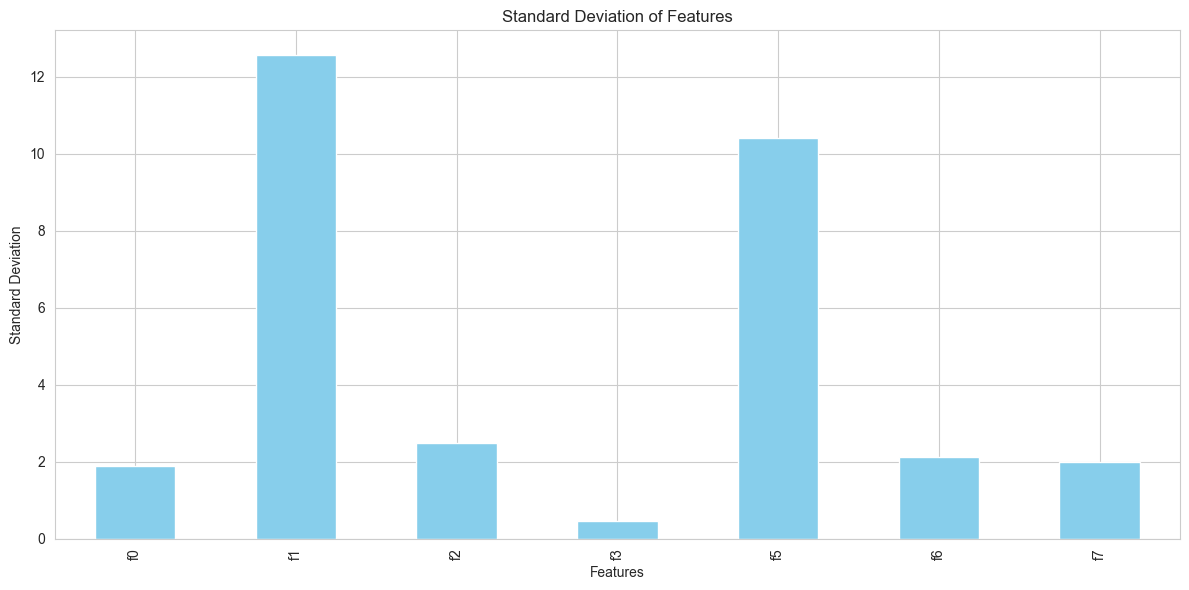

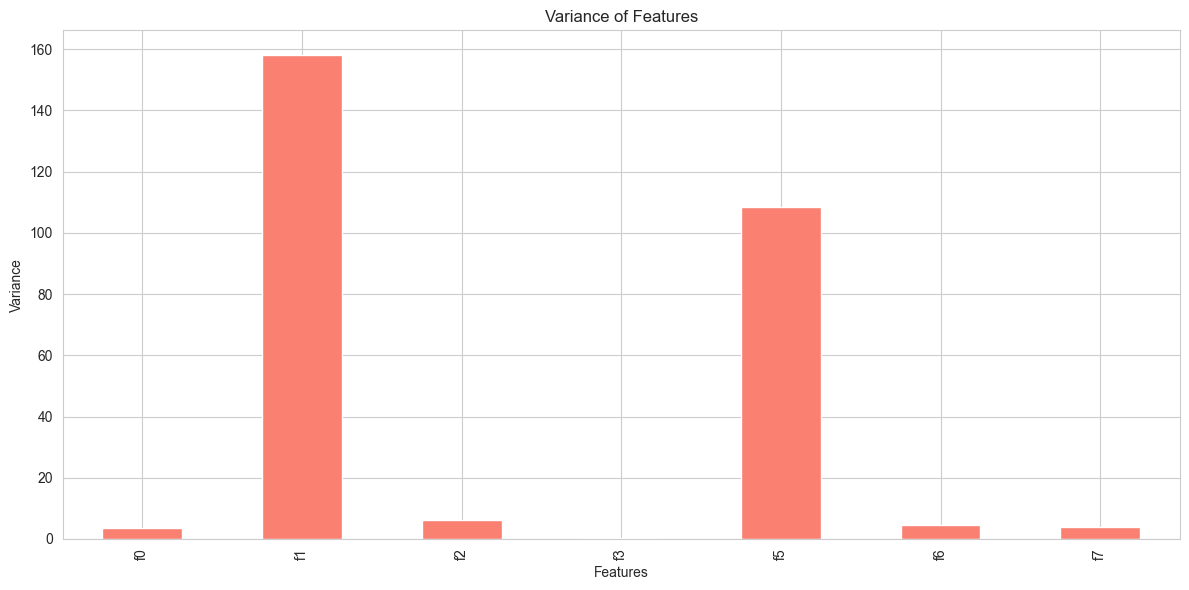

In [6]:
# Plotting STD
std_values = df.std()
filtered_std_values = std_values[std_values <= 200] # we excluded extreme values
plt.figure(figsize=(12, 6))
filtered_std_values.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Features')
plt.xlabel('Features')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plotting variance
var_values = df.var()
filtered_var_values = var_values[std_values <= 200] # we excluded extreme values
plt.figure(figsize=(12, 6))
filtered_var_values.plot(kind='bar', color='salmon')
plt.title('Variance of Features')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.tight_layout()

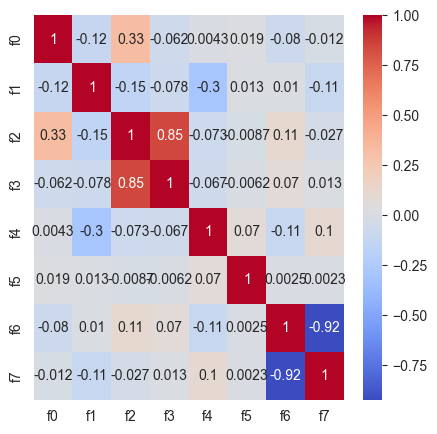

In [7]:
correlation_matrix = df.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Check Number of Null Values for Each Column

In [8]:
pd.concat([train, dev, test]).isnull().sum()

f0        174
f1        140
f2        158
f3        156
f4        169
f5        142
f6        151
f7        148
target      0
dtype: int64

Split the Data to X and Y

In [9]:
x_train = train.drop(columns=['target'])
y_train = train['target']

x_dev = dev.drop(columns=['target'])
y_dev = dev['target']

x_test = test.drop(columns=['target'])
y_test = test['target']

Remove Null Vales

In [10]:
imputer = KNNImputer(n_neighbors=30)
x_train = imputer.fit_transform(x_train)
x_dev = imputer.fit_transform(x_dev)
x_test = imputer.fit_transform(x_test)

In [15]:
models = [
    ('Gradient Boosting', GradientBoostingRegressor(), {
        'n_estimators': [100, 250, 500],
        'learning_rate': [0.2, 0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7, 9, 11],
    }),
    ('LightGBM', LGBMRegressor(force_col_wise=True), {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.2, 0.15 , 0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 9, 11],
    }),
    ('XGBoost', XGBRegressor(objective='reg:squarederror'), {
    'n_estimators': [100, 250, 500, 1000],
    'learning_rate': [0.2, 0.15, 0.1, 0.01, 0.001],
    'max_depth': [5, 7, 9, 11],}),
    ('Random Forest', RandomForestRegressor(), {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],}),
    ('Neural Network', MLPRegressor(), {
    'hidden_layer_sizes': [(5, ), (10,), (25,), (50,)],
    'alpha': [0.0001, 0.001, 0.01],}),
    ('KNNRegressor', KNeighborsRegressor(), {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    })
          ]

Calculate Results

In [16]:
best_regressor_total = None
results = []
# Perform GridSearchCV for each regressor
for i, (name, regressor, param_grid) in enumerate(models):
    print(f"Performing GridSearchCV for {name}")
    grid_search = GridSearchCV(regressor, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    print(f"Best parameters found for {name}:")
    print(grid_search.best_params_)
    print()
    
    # Evaluate the best model on the test set
    best_regressor = grid_search.best_estimator_
    y_pred = best_regressor.predict(x_dev)
    mse = mean_squared_error(y_dev, y_pred)

    results.append((name, mse, grid_search.best_params_, best_regressor))

Performing GridSearchCV for Gradient Boosting
Best parameters found for Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}

Performing GridSearchCV for LightGBM
[LightGBM] [Info] Total Bins 1875
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 2.066362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters found for LightGBM:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}

Performing GridSearchCV for XGBoost
Best parameters found for XGBoost:
{'learning_rat

Plot The Models' Score

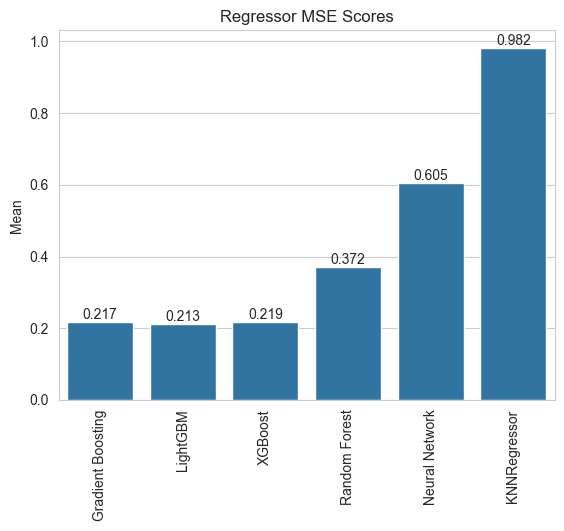

In [17]:
names = [item[0] for item in results]
scores = [item[1] for item in results]

# Create a bar plot using sns.barplot
sns.barplot(x=names, y=scores)
plt.ylabel('Mean')
plt.title('Regressor MSE Scores')

# Annotate the bars with score values
for i, score in enumerate(scores):
    plt.annotate(f'{score:.3f}', (i, score), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.show()

Find the Best Regressor

In [20]:
best_rmse = float('inf')
best_regressor = (None, 0, None, None)

for regressor in results:
    rmse = np.sqrt(regressor[1])
    if rmse < best_rmse:
            best_rmse = rmse
            best_regressor = regressor
            
print(f"The best regressor is: {best_regressor[0]}, with hyperparameters: {best_regressor[2]}, with mse:{best_regressor[1]}")

The best regressor is: LightGBM, with hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}, with mse:0.21311805816503634


Evaluate the Result on the Test-Set

In [21]:
y_pred = best_regressor[3].predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"The test mse is: {mse}")

The test mse is: 0.2157150270396209


We selected the following models: GradientBoostingRegressor, LGBMRegressor, XGBRegressor, RandomForestRegressor, MLPRegressor, and KNeighborsRegressor. Using grid search, we optimized the hyperparameters for each regressor. We evaluated the models using the root mean square error (RMSE) because RMSE is a widely recognized metric for assessing the accuracy of regression models. The regressor with the lowest RMSE was determined to be the best.

The KNNImputer fills missing values by using the k-nearest neighbors' values, preserving the data's underlying structure and relationships. This method is especially beneficial for regressors, as it maintains data integrity and improves model performance by reducing bias from imputed values. Notably, the target column does not have any null values, ensuring the model's predictions remain unaffected by missing target data.

The metric used to evaluate the model on the dev set is Mean Squared Error (MSE). MSE measures the average squared difference between the actual and predicted values, penalizing larger errors more severely. It is suitable for continuous data and aligns well with the optimization objectives of regression algorithms. Using MSE ensures the selected model has minimized prediction errors and generalizes well to new data.

The hyperparameter search involves using GridSearchCV to optimize the settings for each regressor by testing combinations of hyperparameters. For Gradient Boosting, LightGBM, and XGBoost, hyperparameters like n_estimators, learning_rate, and max_depth control the number of trees, the step size at each iteration, and the maximum depth of the trees, respectively, affecting the model's ability to learn complex patterns. Random Forest's n_estimators, max_depth, and min_samples_split influence the number of trees, tree depth, and minimum samples required to split a node, balancing bias and variance. The MLPRegressor's hidden_layer_sizes and alpha determine the network's architecture and regularization, impacting its capacity to fit the data and avoid overfitting. Finally, KNeighborsRegressor's n_neighbors, weights, and metric define the number of neighbors, the weighting scheme, and the distance metric used for prediction, which influence the model's responsiveness to local variations in the data.